# Imports

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib widget
import csv
import datetime
from itertools import accumulate
import json
import logging
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import ScalarFormatter
from multiprocessing import Array, Process, Queue, Value
import numpy as np
import os
import pandas as pd
import random
import re
import subprocess
import sys
import time

In [2]:
from DroneBandit import DroneBandit

# Simulation parameters

In [3]:
P = 9
params = {
    # number of possible partition points
    'P': P,
    # env parameters
    'D_F_def_const': 2e-2, # default value for D_F for all p
    'D_E_def_const': 1e-2, # default value for D_E for all p
    # ANS parameters
    'ANS_ALPHA': 0.1,
    'ANS_BETA': 1.0,
    # map mac units to smaller values: this is the magnitude of the new values
    'MACUNITS_MAP_SPREAD': 1e3,
    # if selected partition point is set to NO partial inference, randomize decision for p every 1/x times
    'RDM_P_TRIGGER': 10,
    
    'USE_BETTER_ANS': True,
    'DELAYS_MAGNITUDE': None,
}

# Fig 3: DroneBandit performance in simulation environment

(417,
 {'Accuracy': 0.9400479616306955,
  'Dumb Weighted Accuracy': 0.9796163069544365,
  'Smart Weighted Accuracy': 0.9784172661870504,
  'Smart Accuracy': 0.9784172661870504})

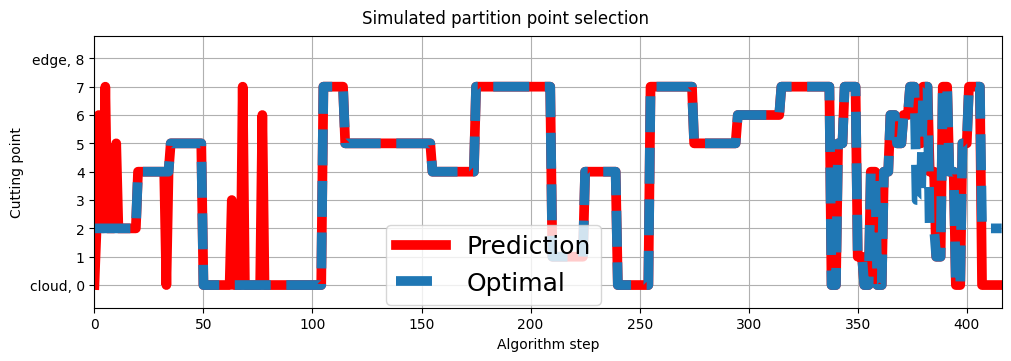

In [4]:
from scenarios.scenario_5 import scenario, DELAYS_MULTIPLYER as DELAYS_MAGNITUDE
params['DELAYS_MAGNITUDE'] = DELAYS_MAGNITUDE
ticks = [0] + list(accumulate(map(lambda args: args[0], scenario)))
scenario = {
    ticks[i]: scenario[i][1:] if i < len(ticks)-1 else None
    for i in range(len(ticks))
}
ps, target_ps, true_rankings, system_params = DroneBandit.run_scenario('contextVector9.csv', scenario, params)
DroneBandit.plot_scenario(ps, target_ps, true_rankings, P, linewidth=7)
len(target_ps), DroneBandit.compute_metrics(P, target_ps, ps, true_rankings)

# Fig 4: ANS vs DroneBandit

In [5]:
nruns = 100
_delays_magnitudes = [-3,-2,-1,0,1,2,3]
exp_results = {}
for use_better_ans in [False, True]:
    params['USE_BETTER_ANS'] = use_better_ans
    results_ = []
    for DELAYS_MAGNITUDE in _delays_magnitudes:
        results_.append([DELAYS_MAGNITUDE, [], []])
        for _ in range(nruns):
            scenario = [
                
                (20, 2, {'d_f': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 32*10**DELAYS_MAGNITUDE], 
                         'd_e': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE]}),
                
                (15, 4, {'d_f': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 32*10**DELAYS_MAGNITUDE], 
                         'd_e': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE]}),
                
                (20, 0, {'d_f': [10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 32*10**DELAYS_MAGNITUDE], 
                         'd_e': [10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE]}),
                
                (10, 1, {'d_f': [48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 32*10**DELAYS_MAGNITUDE], 
                         'd_e': [48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE]}),
            
                (20, 3, {'d_f': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 32*10**DELAYS_MAGNITUDE], 
                         'd_e': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE]}),
                
                (5, 2, {'d_f': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 32*10**DELAYS_MAGNITUDE], 
                        'd_e': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE]}),
            
                (5, 6, {'d_f': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 32*10**DELAYS_MAGNITUDE], 
                        'd_e': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE]}),
                
                (15, 8, {'d_f': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 32*10**DELAYS_MAGNITUDE], 
                         'd_e': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE]}),
            
                (10, 6, {'d_f': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 32*10**DELAYS_MAGNITUDE], 
                         'd_e': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE]}),
                
                (5, 7, {'d_f': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 32*10**DELAYS_MAGNITUDE], 
                        'd_e': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE]}),
                
                (10, 8, {'d_f': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 32*10**DELAYS_MAGNITUDE], 
                         'd_e': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE]}),
            
                (3, 4, {'d_f': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 32*10**DELAYS_MAGNITUDE], 
                        'd_e': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE]}),
                
                (20, 3, {'d_f': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 32*10**DELAYS_MAGNITUDE], 
                         'd_e': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE]}),
                
                (15, 1, {'d_f': [48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 32*10**DELAYS_MAGNITUDE], 
                         'd_e': [48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE]}),
                
                (15, 4, {'d_f': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 32*10**DELAYS_MAGNITUDE], 
                         'd_e': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE]}),
                
                (15, 0, {'d_f': [10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 32*10**DELAYS_MAGNITUDE], 
                         'd_e': [10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE]}),
            
            
                
                (3, 7, {'d_f': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 32*10**DELAYS_MAGNITUDE], 
                        'd_e': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE]}),
                
                (3, 0, {'d_f': [10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 32*10**DELAYS_MAGNITUDE], 
                        'd_e': [10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE]}),
                
                (3, 5, {'d_f': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 32*10**DELAYS_MAGNITUDE], 
                        'd_e': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE]}),
                
                (3, 7, {'d_f': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 32*10**DELAYS_MAGNITUDE], 
                        'd_e': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE]}),
                
                (3, 8, {'d_f': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 32*10**DELAYS_MAGNITUDE], 
                        'd_e': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE]}),
                
                (3, 7, {'d_f': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 32*10**DELAYS_MAGNITUDE], 
                        'd_e': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE]}),
                
                (3, 1, {'d_f': [48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 32*10**DELAYS_MAGNITUDE], 
                        'd_e': [48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE]}),
                
                (3, 0, {'d_f': [10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 32*10**DELAYS_MAGNITUDE], 
                        'd_e': [10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE]}),
                
                (3, 4, {'d_f': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 32*10**DELAYS_MAGNITUDE], 
                        'd_e': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE]}),
                
                (3, 0, {'d_f': [10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 32*10**DELAYS_MAGNITUDE], 
                         'd_e': [10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE]}),
                
                (3, 4, {'d_f': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 32*10**DELAYS_MAGNITUDE], 
                         'd_e': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE]}),
                
                (3, 6, {'d_f': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 32*10**DELAYS_MAGNITUDE], 
                        'd_e': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE]}),
                
                (3, 5, {'d_f': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 32*10**DELAYS_MAGNITUDE], 
                        'd_e': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE]}),
                
                (3, 6, {'d_f': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 32*10**DELAYS_MAGNITUDE], 
                        'd_e': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE]}),
                
                (3, 7, {'d_f': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 32*10**DELAYS_MAGNITUDE], 
                        'd_e': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE]}),
            
            
                
                (10, 0, {'d_f': [10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 32*10**DELAYS_MAGNITUDE], 
                          'd_e': [10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE]}),
                
                (30, 8, {'d_f': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 32*10**DELAYS_MAGNITUDE], 
                         'd_e': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE]}),
                
                (10, 7, {'d_f': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 32*10**DELAYS_MAGNITUDE], 
                         'd_e': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE]}),
                
                (15, 1, {'d_f': [48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 32*10**DELAYS_MAGNITUDE], 
                        'd_e': [48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE]}),
                
                (15, 4, {'d_f': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 32*10**DELAYS_MAGNITUDE], 
                         'd_e': [48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 10*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE, 48*10**DELAYS_MAGNITUDE]}),
            ]
            params['DELAYS_MAGNITUDE'] = DELAYS_MAGNITUDE
        
            ticks = [0] + list(accumulate(map(lambda args: args[0], scenario)))
            scenario = {
                ticks[i]: scenario[i][1:] if i < len(ticks)-1 else None
                for i in range(len(ticks))
            }
            assert all(i[0] >= 0 and i[0] < P for i in list(scenario.values())[:-1])
            ps, target_ps, true_rankings, _ = DroneBandit.run_scenario('contextVector9.csv', scenario, params)
            metrics = DroneBandit.compute_metrics(P, target_ps, ps, true_rankings)

            #print('DroneBandit: %s - Delays order of mag.: %.0e, Accuracy: %.3f' % (use_better_ans, 10**DELAYS_MAGNITUDE, metrics['Accuracy']))
            #DroneBandit.plot_scenario(ps, target_ps, true_rankings, P, linewidth=4)
            #plt.show()
            
            #print(metrics)
            results_[-1][1].append(metrics['Accuracy'])
            results_[-1][2].append(metrics['Smart Accuracy'])
        results_[-1][1] = np.mean(results_[-1][1])
        results_[-1][2] = np.mean(results_[-1][2])
    exp_results[use_better_ans] = results_

DroneBandit: 0.823, ANS: 0.436


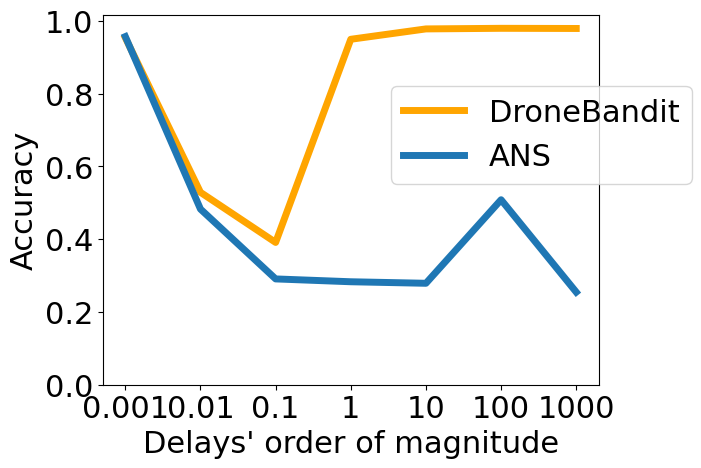

In [6]:
fig = plt.figure()
ax = plt.axes()
x_ticks = _delays_magnitudes
x1 = [exp_results[True][i][1] for i in range(len(x_ticks))]
x2 = [exp_results[False][i][1] for i in range(len(x_ticks))]
ax.plot(x_ticks, x1,
        color='orange', linestyle='-', linewidth=5, label='DroneBandit')
#ax.plot(x_ticks, [exp_results[True][i][2] for i in range(len(x_ticks))],
#        color='orange', linestyle='--', linewidth=5, label='DroneBandit - Top 3 Accuracy')
ax.plot(x_ticks, x2,
        color='C0', linestyle='-', linewidth=5, label='ANS')
#ax.plot(x_ticks, [exp_results[False][i][2] for i in range(len(x_ticks))],
#        color='C0', linestyle='--', linewidth=5, label='ANS - Top 3 Accuracy')
ax.legend(bbox_to_anchor=(0.55, 0.85))
ax.set_xlabel('Delays\' order of magnitude')
ax.set_ylabel('Accuracy')
ax.set_xticks(x_ticks, [10**x for x in _delays_magnitudes])
ax.set_yticks(np.round(np.arange(0,1.1,0.2),1), np.round(np.arange(0,1.1,0.2),1))
print('DroneBandit: %.3f, ANS: %.3f' % (np.mean(x1), np.mean(x2)))

# Fig 6: Distribution of the execution time

In [7]:
EDGE_DELAYS = [
    26,
    53,
    81,
    107,
    133,
    160,
    186,
    216,
    241,
]
TENSORS_DIM = [
    1 * 200 * 200, # 0
    4 * 100 * 100,
    4 * 100 * 100,
    8 * 50 * 50,
    8 * 50 * 50,
    16 * 25 * 25,
    16 * 25 * 25,
    64,
    0, # 8
]

In [8]:
with open('fig6_dronebandit_measurements.csv') as f:
    lines = f.readlines()
    
newlines = []
i = 1
while i < len(lines)-1:
    if lines[i][0] == '0' and lines[i+1][0] == '1':
        s = (lines[i+1][2:] + ',' + lines[i][2:]).replace('\n', '')
        assert len(s.split(',')) == 33, i
        newlines.append(s.split(','))
    elif lines[i+1][0] == '0':
        i -= 1
    i += 2

df = pd.DataFrame(newlines, columns=lines[0].replace('\n', '').split(','))
df = df.astype('float64')

get_target_p = lambda row: np.argmin(row[:P].to_numpy() + np.append(row[P:P+P-1].to_numpy(), 0))
df['target_p'] = df.apply(get_target_p, axis=1)
for i in range(P):
    try:
        df['edge+serv[%i]' % i] = df['edge[%i]' % i] + df['serv[%i]' % i]
    except:
        df['edge+serv[%i]' % i] = df['edge[%i]' % i]
df['total_target_time'] = [df['edge+serv[%i]' % p].iloc[i] for i, p in enumerate(df['target_p'])]
df['total_effective_time'] = [df['edge+serv[%i]' % p].iloc[i] for i, p in enumerate(df['cp'])]
df['time_gain'] = df['total_effective_time'] - df['total_target_time']

df['throughput'] = df.tx / pd.Series([TENSORS_DIM[int(p)] for p in df.cp])
for i in range(P-1):
    df['throughput[%i]' % i] = df['tx[%i]' % i] / TENSORS_DIM[i]
df['med_throughput'] = df[[c for c in df.columns if 'throughput' in c]].median(axis=1)
df['avg_throughput'] = df[[c for c in df.columns if 'throughput' in c]].mean(axis=1)

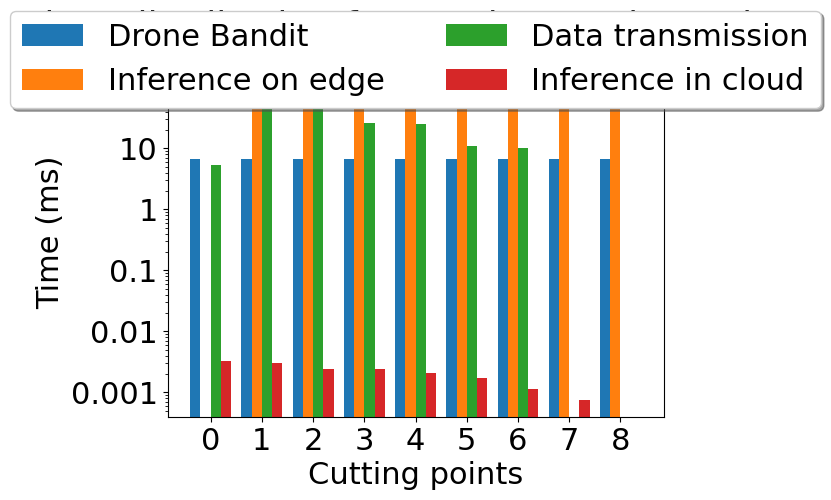

In [9]:
x = np.arange(P)
y = np.array([
    (
        df['ans'].mean(), 
        df['edge[%i]' % p].mean(), 
        df.loc[(df['serv[%i]' % p] < 2000) & (df['tx[%i]' % p] < 2000)]['tx[%i]' % p].mean(), 
        (df['serv[%i]' % p] - df['tx[%i]' % p]).mean()
    ) for p in range(1, P)
])

y = np.insert(y, 0, 0, axis=0)
y[0][0] = df['ans'].mean()
y[0][1] = 0
y[0][2] = df['serv[0]'].mean() - df['tx[0]'].mean()
y[0][3] = 0

y = y.T

y[3] = [
    0.0032296538352966308,
    0.003058949696648981,
    0.002440810203552246,
    0.0024129152297973633,
    0.002080678939819336,
    0.0017098188400268555,
    0.0011262098948160808,
    0.0007548332214355469,
    0,
]

bar_width = 0.2

fig = plt.figure()
ax = plt.axes()

plt.bar(x-bar_width*1.5, y[0], bar_width, label='Drone Bandit',) 
plt.bar(x-bar_width*0.5, y[1], bar_width, label='Inference on edge',) 
plt.bar(x+bar_width*0.5, y[2], bar_width, label='Data transmission',)
plt.bar(x+bar_width*1.5, y[3], bar_width, label='Inference in cloud',)

ax.set_xticks(x, x)

ax.set_xlabel('Cutting points')
ax.set_ylabel('Time (ms)')
ax.set_title('Time distribution for varying cutting points')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.14),
          ncol=2, fancybox=True, shadow=True)

ax.set_yscale('log')
ax = plt.gca()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_yticks([0.001, 0.01, 0.1, 1, 10, 100], [0.001, 0.01, 0.1, 1, 10, 100])

fig = plt.gcf()
plt.rcParams.update({'font.size': 18})
plt.show()

# Fig 7: Overall time taken by server inference & transmission

In [10]:
with open('fig7_dronebandit_measurements.csv') as f:
    lines = f.readlines()
    
newlines = []
i = 1
while i < len(lines)-1:
    if lines[i][0] == '0' and lines[i+1][0] == '1':
        s = (lines[i+1][2:] + ',' + lines[i][2:]).replace('\n', '')
        newlines.append(s.split(','))
    elif lines[i+1][0] == '0':
        i -= 1
    i += 2

df = pd.DataFrame(newlines, columns=lines[0].replace('\n', '').split(','))
df = df.astype('float64')

df['throughput'] = df.tx / pd.Series([TENSORS_DIM[int(p)] for p in df.cp])
df['estimated_serv'] = [df['estimate[%i]' % p].iloc[i] for i,p in enumerate(df.cp)]

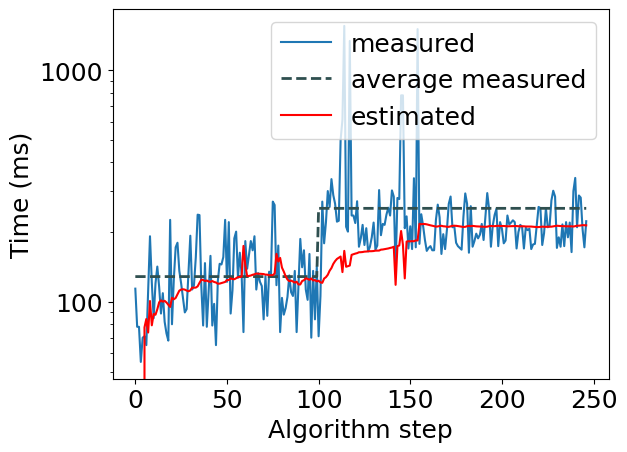

In [11]:
fig = plt.figure()
ax = plt.axes()
max_x = 247
ax.plot(df.serv.iloc[:max_x], label='measured') # , color='#ff3902'
ax.plot(
    np.append(np.repeat(df.serv.iloc[:100].mean(), 100),
              np.repeat(df.serv.iloc[100:max_x].mean(), max_x-100)),
    label='average measured', linewidth=2, color='darkslategrey', linestyle='--')
ax.plot(df.estimated_serv.iloc[:max_x], label='estimated', color='red')
ax.legend()
ax.set_yscale('log')
ax = plt.gca()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())

ax.set_xlabel('Algorithm step')
ax.set_ylabel('Time (ms)')
plt.rcParams.update({'font.size': 12})
plt.show()